<a href="https://colab.research.google.com/github/vanshuwjoshi/End-To-End-ML/blob/main/End_To_End_ML_Problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from pathlib import Path
import pandas as pd
import tarfile ## to read and write tar archives
import urllib.request

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use("ggplot")

In [3]:
## Load the data
def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

In [4]:
housing = load_housing_data()

In [5]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [6]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [7]:
housing.shape

(20640, 10)

- Here, we are given the data of districts (or small areas) in California. We have to make a model to predict "median_house_value".
- Only total_bedrooms are missing some values.
- Only ocean_proximity is of object type.

In [8]:
## Check for categories in a categorical variable
housing["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [9]:
## Looking at other fields
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


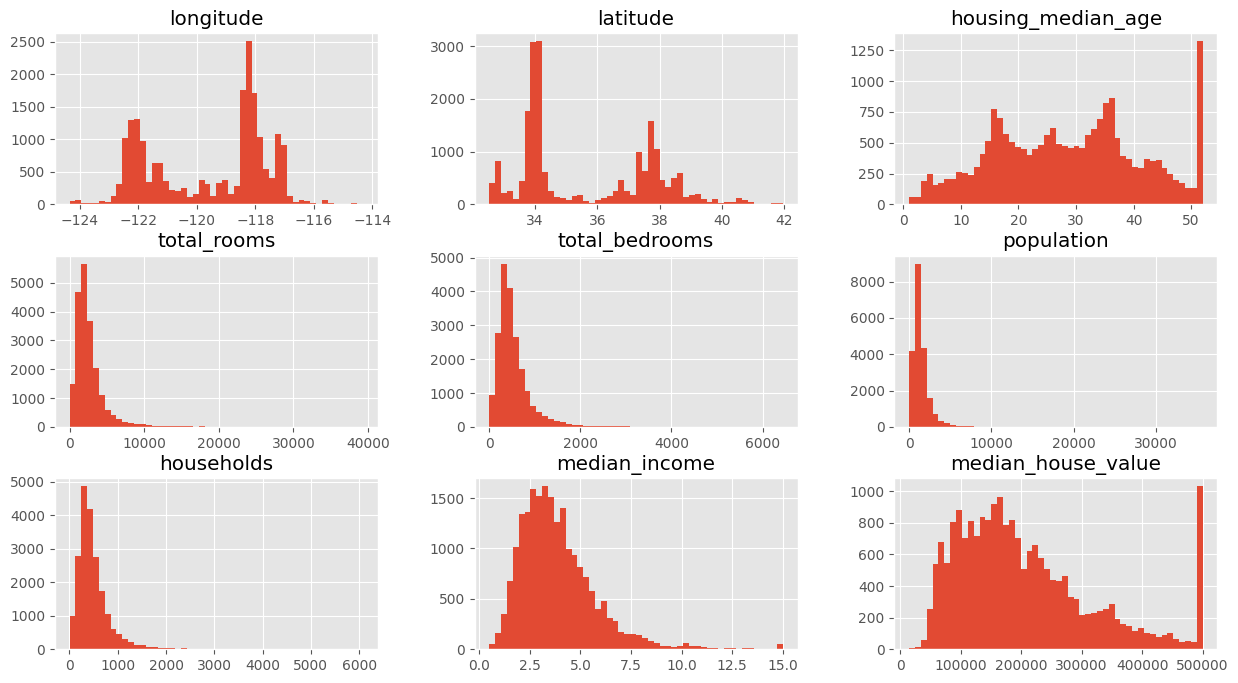

In [10]:
housing.hist(bins=50, figsize=(15,8))
plt.show()

- median_income is not in USD. It it represented in roughly ten thousand (3 means $30,000).
- Looks like median_house_value and housing_median_age are capped after a certian point. Like median_house_value after 500000 is all taken at 500000. This is a big problem as our model will think that price never goes beyond 500000. If we need to get exact price even beyond 500000, we have two options:
    - Get correct data
    - Remove those districts from the training and test data
- The features have very different scales. We need to perform **feature scaling**.
- The features are right skewed. Need to transform the data.

## Creating a test dataset

The concept of taking away the test dataset at this point is so that we dont make a bias in our brain for the whole dataset.

Could simply use train_test_split, however, we try to do a **Stratified Sampling**.

### Stratified Sampling:
We create categories of median_income (as we got to know median_income is important factor in median_house_value). Then we sample the test data in such a way that it will represent the whole data (proportions of median_income category of test data will be similar to the population data).

In [11]:
import numpy as np
## [0,1.5) as 1, [1.5,3.0) as 2, [3.0,4.5) as 3, [4.5,6.0) as 4, [6.0,inf) as 5
housing["income_cat"] = pd.cut(housing["median_income"],
                              bins=[0,1.5,3.0,4.5,6.0,np.inf],
                              labels=[1,2,3,4,5])

In [12]:
housing["income_cat"].value_counts()

income_cat
3    7236
2    6581
4    3639
5    2362
1     822
Name: count, dtype: int64

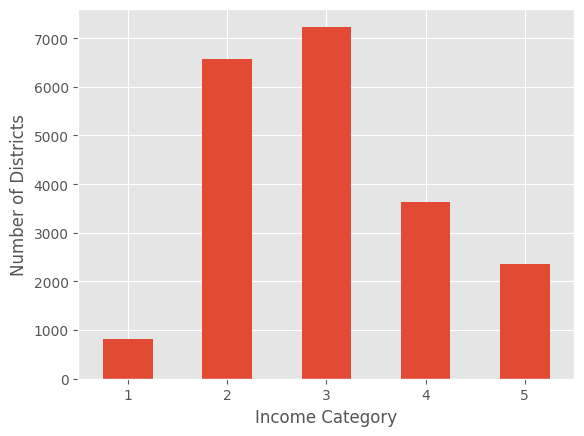

In [13]:
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0)
plt.xlabel("Income Category")
plt.ylabel("Number of Districts")
plt.show()

In [14]:
from sklearn.model_selection import train_test_split
strat_train_set, strat_test_set = train_test_split(housing,
                                                   test_size=0.2,
                                                   stratify=housing["income_cat"],
                                                   random_state=42)

In [15]:
housing["income_cat"].value_counts()/len(housing)

income_cat
3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: count, dtype: float64

In [16]:
strat_test_set["income_cat"].value_counts()/len(strat_test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

We were able to get similar proportions in test set compared to population set.

In [17]:
len(strat_test_set)

4128

In [18]:
len(strat_train_set)

16512

In [19]:
## Removing the income_cat from both train and test set
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [20]:
strat_train_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987,458300.0,NEAR BAY
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876,483800.0,<1H OCEAN
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330,101700.0,INLAND
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618,96100.0,INLAND
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292,361800.0,NEAR OCEAN


In [21]:
housing = strat_train_set.copy()

## Data Visualization

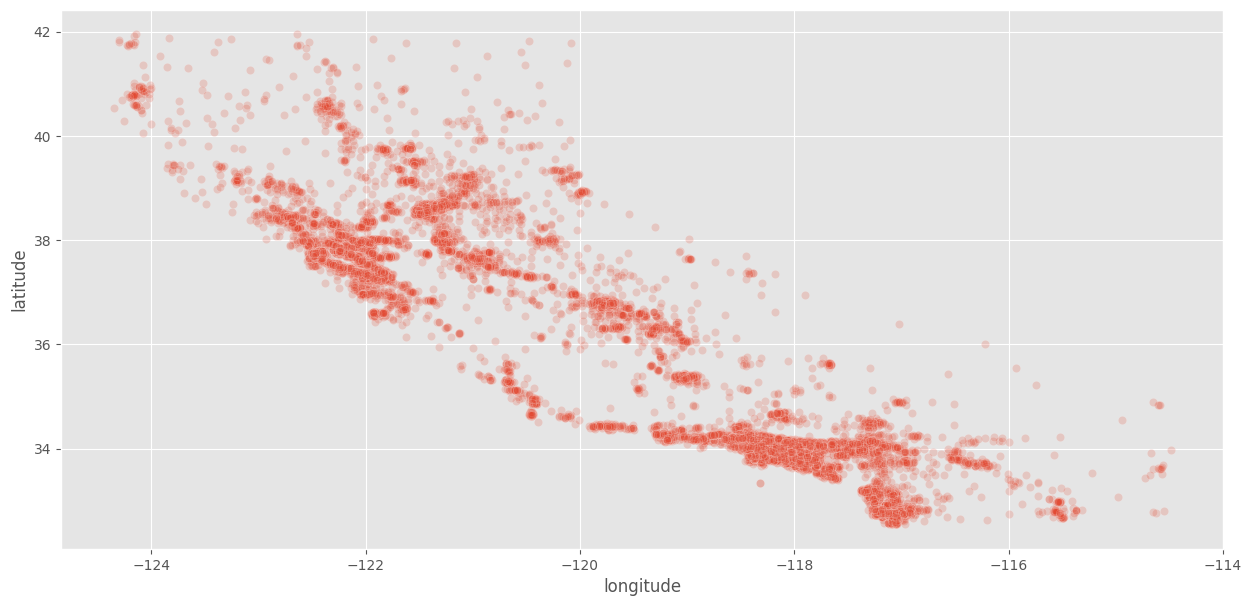

In [22]:
plt.figure(figsize=(15,7))
sns.scatterplot(data=housing, x="longitude", y="latitude",alpha=0.2)
plt.show()

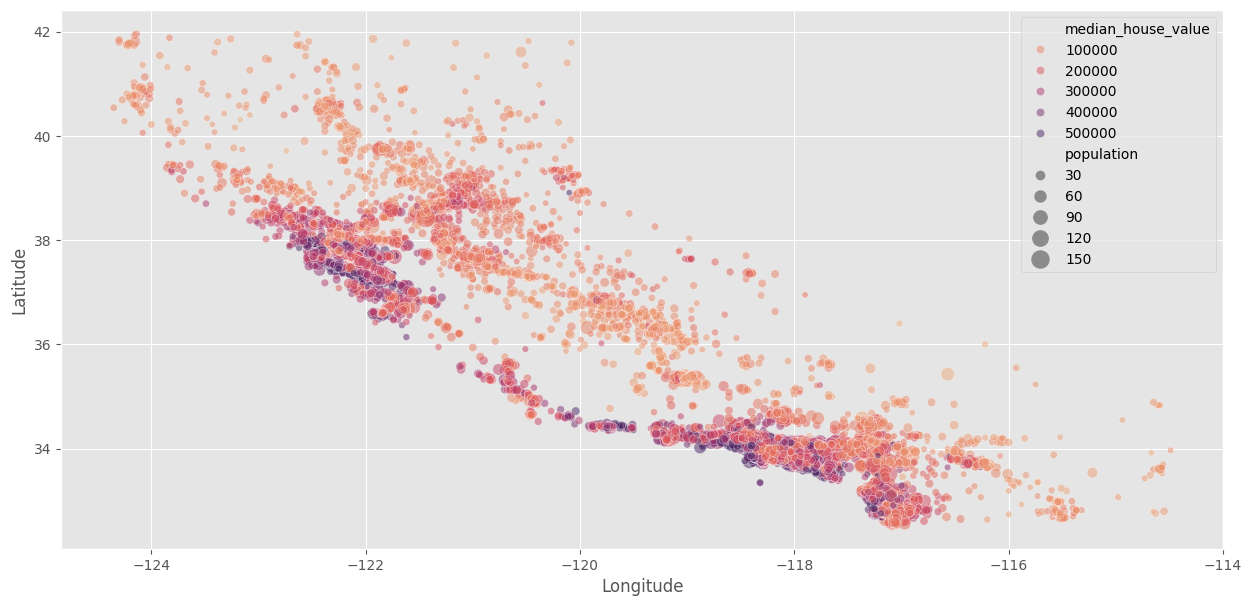

In [23]:
plt.figure(figsize=(15,7))
sns.scatterplot(data=housing, x="longitude", y="latitude",
               size=housing["population"]/100,
               hue="median_house_value",
               palette=sns.color_palette("flare", as_cmap=True),
               sizes=(20, 200),
               alpha=0.5)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

- The house price really depend on location (like close to water body) and population density.

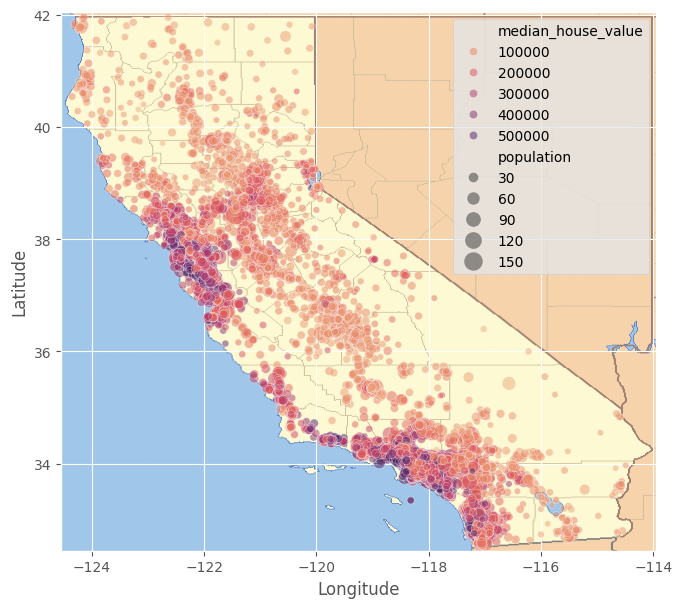

In [35]:
## Interesting Plot
filename = "california.png"
plt.figure(figsize=(15,7))
sns.scatterplot(data=housing, x="longitude", y="latitude",
               size=housing["population"]/100,
               hue="median_house_value",
               palette=sns.color_palette("flare", as_cmap=True),
               sizes=(20, 200),
               alpha=0.5)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
california_img = plt.imread(filename)
axis = -124.55, -113.95, 32.45, 42.05
plt.axis(axis)
plt.imshow(california_img, extent=axis)
plt.show()

## Working with Correlations

In [25]:
corr_matrix = housing.corr(numeric_only=True)
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924213,-0.102937,0.044558,0.068210,0.104236,0.054261,-0.016542,-0.050859
latitude,-0.924213,1.000000,0.005692,-0.036753,-0.066391,-0.115677,-0.071604,-0.078137,-0.139584
housing_median_age,-0.102937,0.005692,1.000000,-0.361710,-0.317978,-0.301906,-0.300075,-0.127043,0.102175
total_rooms,0.044558,-0.036753,-0.361710,1.000000,0.930076,0.863967,0.916143,0.197720,0.137455
total_bedrooms,0.068210,-0.066391,-0.317978,0.930076,1.000000,0.886200,0.978822,-0.006038,0.054635
population,0.104236,-0.115677,-0.301906,0.863967,0.886200,1.000000,0.916237,0.004282,-0.020153
households,0.054261,-0.071604,-0.300075,0.916143,0.978822,0.916237,1.000000,0.013637,0.071426
median_income,-0.016542,-0.078137,-0.127043,0.197720,-0.006038,0.004282,0.013637,1.000000,0.688380
median_house_value,-0.050859,-0.139584,0.102175,0.137455,0.054635,-0.020153,0.071426,0.688380,1.000000


In [26]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

- Median income has high positive correlation.
- Latitude has small negative correaltion (going higher up the area the price tend to decrease)

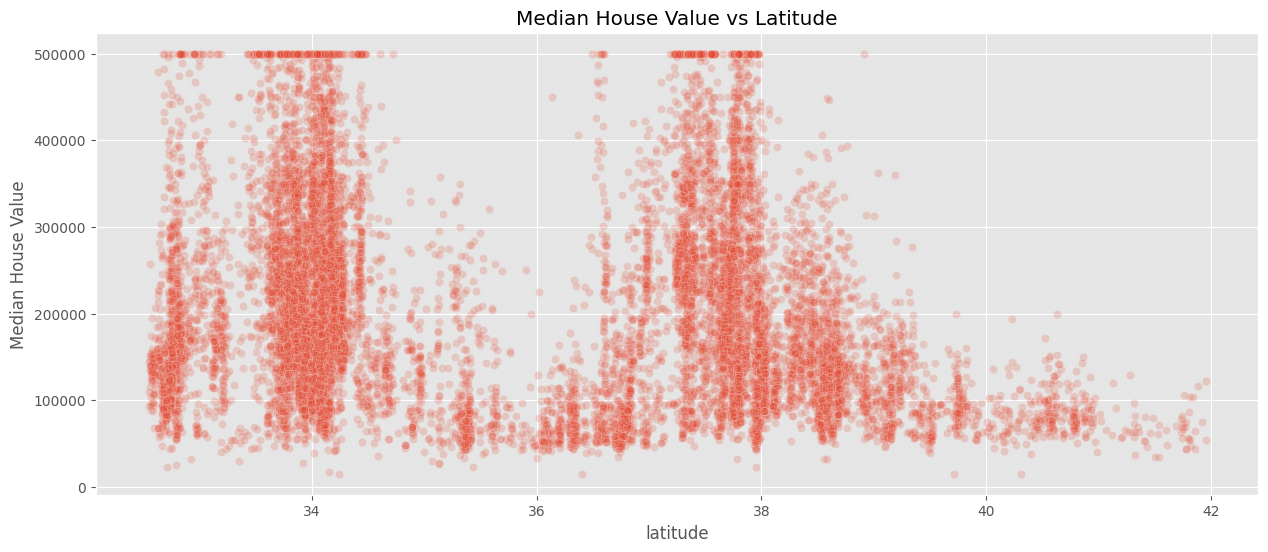

In [27]:
plt.figure(figsize=(15,6))
sns.scatterplot(data=housing, x="latitude",y="median_house_value", alpha=0.2)
plt.xlabel("latitude")
plt.ylabel("Median House Value")
plt.title("Median House Value vs Latitude")
plt.show()

- As we increase the latitude the median value does decrease.
- Around latitude 36 there is a fall in the median house values.

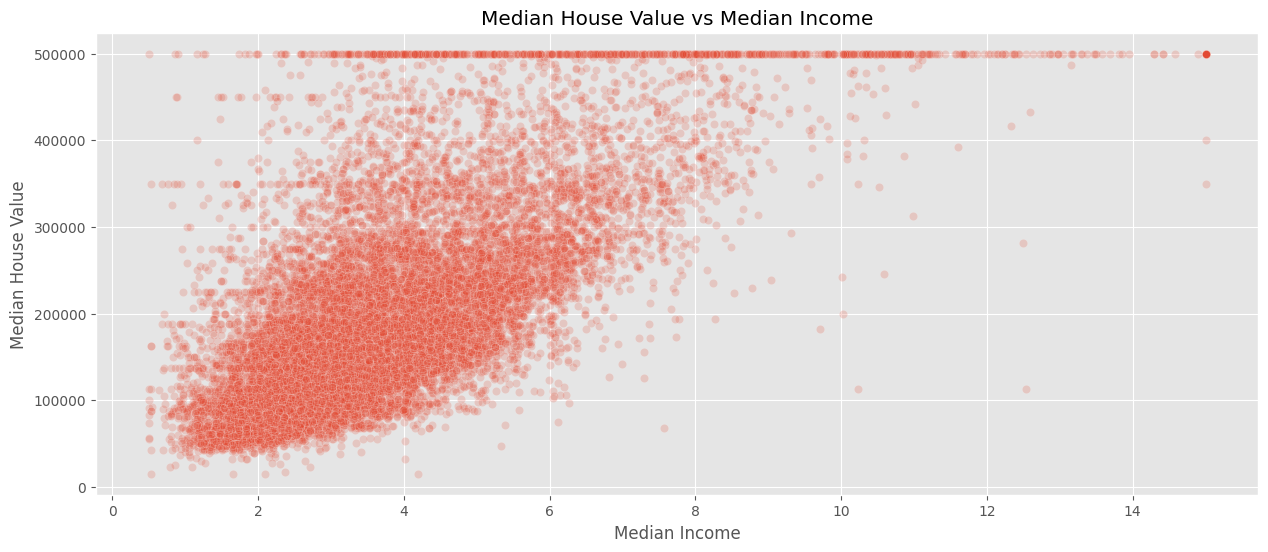

In [28]:
plt.figure(figsize=(15,6))
sns.scatterplot(data=housing, x="median_income",y="median_house_value", alpha=0.2)
plt.xlabel("Median Income")
plt.ylabel("Median House Value")
plt.title("Median House Value vs Median Income")
plt.show()

- Clearly observe a positive correlation.
- Can also observe the price cap at $500000.
- Also there is a straight line at around 450000, and 350000.

## Attribute Combinations

In [29]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987,458300.0,NEAR BAY
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876,483800.0,<1H OCEAN
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330,101700.0,INLAND
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618,96100.0,INLAND
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292,361800.0,NEAR OCEAN


In [30]:
## Trying three combinations
## total_rooms, total_bedrooms, does not provide any information. Can get average rooms and bedrooms per household
housing["rooms_per_house"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["people_per_house"] = housing["population"]/housing["households"]
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_house,bedrooms_ratio,people_per_house
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987,458300.0,NEAR BAY,3.211799,0.335742,1.524178
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876,483800.0,<1H OCEAN,5.504202,0.180153,1.865546
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330,101700.0,INLAND,5.334975,0.200369,2.768473
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618,96100.0,INLAND,5.351282,0.203881,2.365385
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292,361800.0,NEAR OCEAN,3.725256,0.277371,1.631399


In [32]:
corr_matrix = housing.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
rooms_per_house       0.143663
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
people_per_house     -0.038224
longitude            -0.050859
latitude             -0.139584
bedrooms_ratio       -0.256397
Name: median_house_value, dtype: float64

- bedrooms_ratio is much more correlated to median_house_value compared to total_bedrooms (can keep it). Smaller the ratio of bedrooms/rooms higher the median price of house.
- rooms_per_house is also slightly more correlated and more informative than total_rooms. More rooms higher the price.

## Data Prepration

In [36]:
housing_X = strat_train_set.drop("median_house_value",axis=1)
housing_y = strat_train_set["median_house_value"].copy()
housing_X.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987,NEAR BAY
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876,<1H OCEAN
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330,INLAND
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618,INLAND
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292,NEAR OCEAN


#### Missing Values
There are three options:
- Remove the rows with missing values.
- Remove the column with missing values.
- Impute the missing values with something (generally mean, median, mode, constant value)
- Mean and Median works for numerical values only.
- Other powerful imputers are KNNImputer, IterativeImputer (in sklearn.imputer package)

In [37]:
housing_X.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        168
population              0
households              0
median_income           0
ocean_proximity         0
dtype: int64

In [40]:
## We impute the total_bedrooms with Median
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

In [41]:
housing_X_numericals = housing_X.select_dtypes(include=[np.number])

In [42]:
imputer.fit(housing_X_numericals)

SimpleImputer(strategy='median')

In [43]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

This is the median of all the numerical columns of the housing_X. The idea is to use imputer on whole dataset rather than the missing value column, because we cannot be sure that there won't be any missing values in the new data after system goes live.

In [47]:
## Transform the housing_X_numerical data
X = imputer.transform(housing_X_numericals)
X[0:5]

array([[-1.2242e+02,  3.7800e+01,  5.2000e+01,  3.3210e+03,  1.1150e+03,
         1.5760e+03,  1.0340e+03,  2.0987e+00],
       [-1.1838e+02,  3.4140e+01,  4.0000e+01,  1.9650e+03,  3.5400e+02,
         6.6600e+02,  3.5700e+02,  6.0876e+00],
       [-1.2198e+02,  3.8360e+01,  3.3000e+01,  1.0830e+03,  2.1700e+02,
         5.6200e+02,  2.0300e+02,  2.4330e+00],
       [-1.1711e+02,  3.3750e+01,  1.7000e+01,  4.1740e+03,  8.5100e+02,
         1.8450e+03,  7.8000e+02,  2.2618e+00],
       [-1.1815e+02,  3.3770e+01,  3.6000e+01,  4.3660e+03,  1.2110e+03,
         1.9120e+03,  1.1720e+03,  3.5292e+00]])

The transform returns a Array. So convert it into pd.DataFrame

In [48]:
housing_X_transformed = pd.DataFrame(X, columns=housing_X_numericals.columns,
                                     index=housing_X_numericals.index)
housing_X_transformed.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292


In [49]:
housing_X_transformed.isna().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
dtype: int64